## Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/runs

/content/drive/MyDrive/runs


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vbookshelf/respiratory-sound-database")

print("Path to dataset files:", path)

KeyboardInterrupt: 

In [ ]:
import shutil
import os

# Source path
source_path = "/root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2"

# Destination path
dest_path = "/content/drive/MyDrive/runs"

try:
    # Create the destination directory if it doesn't exist
    os.makedirs(dest_path, exist_ok=True)

    # Copy all contents from source to destination
    for item in os.listdir(source_path):
        source_item = os.path.join(source_path, item)
        dest_item = os.path.join(dest_path, item)

        if os.path.isdir(source_item):
            # If it's a directory, copy the entire directory
            shutil.copytree(source_item, dest_item)
        else:
            # If it's a file, copy the file
            shutil.copy2(source_item, dest_item)

    print("Files successfully moved to:", dest_path)
    print("\nContents of destination directory:")
    print(os.listdir(dest_path))

except Exception as e:
    print(f"An error occurred: {str(e)}")

Files successfully moved to: /content/drive/MyDrive/runs

Contents of destination directory:
['detect', 'respiratory_sound_database', 'demographic_info.txt', 'Respiratory_Sound_Database']


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
import os

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
# to check if tensorflow is using gpu or not
len(tf.config.list_physical_devices('GPU')) > 0

True

Understanding Provided Data

In [ ]:
# os.getcwd()
patient_data = pd.read_csv('/content/drive/MyDrive/runs/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv',names=['pid','disease'])

In [ ]:
# printing patient id and disease info
patient_data.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [ ]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pid      126 non-null    int64 
 1   disease  126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [ ]:
# knowing the audio text files
df = pd.read_csv("Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/203_1p4_Tc_mc_AKGC417L.txt",sep='\t',names=['start','end','crackles','wheezes'])
df.head()

,start,end,crackles,wheezes
0,0.685,2.208,0,0
1,2.208,4.577,1,0
2,4.577,6.970,1,0
3,6.970,9.351,0,0
4,9.351,11.851,0,0


The annotation text files have four columns:
- Beginning of respiratory cycle(s)
- End of respiratory cycle(s)
- Presence/absence of crackles (presence=1, absence=0)
- Presence/absence of wheezes (presence=1, absence=0)

We can extract info from the file names also as:
Each audio file name is divided into 5 elements, separated with underscores (_).

1. Patient number (101,102,...,226)
2. Recording index
3. Chest location

      a. Trachea (Tc)

      b. Anterior left (Al)

      c. Anterior right (Ar)

      d. Posterior left (Pl)

      e. Posterior right (Pr)

      f. Lateral left (Ll)

      g. Lateral right (Lr)

4. Acquisition mode

     a. sequential/single channel (sc),

     b. simultaneous/multichannel (mc)

5. Recording equipment

     a. AKG C417L Microphone (AKGC417L),

     b. 3M Littmann Classic II SE Stethoscope (LittC2SE),

     c. 3M Litmmann 3200 Electronic Stethoscope (Litt3200),
     
     d.  WelchAllyn Meditron Master Elite Electronic Stethoscope (Meditron)

In [ ]:
# taking the file names
import os
path='Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]
files[:5]

['160_1b4_Tc_mc_AKGC417L',
 '160_1b2_Ar_mc_AKGC417L',
 '158_1p4_Al_mc_AKGC417L',
 '160_1b4_Pl_mc_AKGC417L',
 '158_2p2_Ar_mc_AKGC417L']

In [ ]:
def getFilenameInfo(file):
    return file.split('_')

In [ ]:
getFilenameInfo('101_1b1_Al_sc_Meditron')

['101', '1b1', 'Al', 'sc', 'Meditron']

In [ ]:
files_data=[]
for file in files:
    data=pd.read_csv(path + file + '.txt',sep='\t',names=['start','end','crackles','wheezes'])
    name_data=getFilenameInfo(file)
    data['pid']=name_data[0]
    data['mode']=name_data[-2]
    data['filename']=file
    files_data.append(data)
files_df=pd.concat(files_data)
files_df.reset_index()
files_df.head()

,start,end,crackles,wheezes,pid,mode,filename
0,1.962,6.553,0,1,160,mc,160_1b4_Tc_mc_AKGC417L
1,6.553,11.160,0,1,160,mc,160_1b4_Tc_mc_AKGC417L
2,11.160,15.401,0,1,160,mc,160_1b4_Tc_mc_AKGC417L
3,15.401,19.841,0,1,160,mc,160_1b4_Tc_mc_AKGC417L
0,0.109,4.766,0,1,160,mc,160_1b2_Ar_mc_AKGC417L


Join Patient Data with our Files DataFrame

In [ ]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pid      126 non-null    int64 
 1   disease  126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [ ]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6898 entries, 0 to 3
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     6898 non-null   float64
 1   end       6898 non-null   float64
 2   crackles  6898 non-null   int64  
 3   wheezes   6898 non-null   int64  
 4   pid       6898 non-null   object 
 5   mode      6898 non-null   object 
 6   filename  6898 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 431.1+ KB


Jo join based on pid, we need to make the datatype of pid in both the files same.

In [ ]:
patient_data.pid=patient_data.pid.astype('int32')
files_df.pid=files_df.pid.astype('int32')

Finally, we can merge to create our data

In [ ]:
data=pd.merge(files_df,patient_data,on='pid')
data.head()

,start,end,crackles,wheezes,pid,mode,filename,disease
0,1.962,6.553,0,1,160,mc,160_1b4_Tc_mc_AKGC417L,COPD
1,6.553,11.160,0,1,160,mc,160_1b4_Tc_mc_AKGC417L,COPD
2,11.160,15.401,0,1,160,mc,160_1b4_Tc_mc_AKGC417L,COPD
3,15.401,19.841,0,1,160,mc,160_1b4_Tc_mc_AKGC417L,COPD
4,0.109,4.766,0,1,160,mc,160_1b2_Ar_mc_AKGC417L,COPD


Saving our output in csv format

In [ ]:
isCsvDataExist = os.path.exists('csv_data')
if(not isCsvDataExist):
    os.makedirs('csv_data')
    data.to_csv('csv_data/data.csv',index=False)
isCsvDataExist

True

We only want that parts from whole audio file which contains Respiratory Cycles.

We will utilize the start and end time specified for these cycles in our data dataframe

In [ ]:
'''
    Takes a numpy array and spilts its using start and end args

    raw_data=numpy array of audio sample
    start=time
    end=time
    sr=sampling_rate
    mode=mono/stereo
    by default librosa gives sr=22050
'''
def getPureSample(raw_data,start,end,sr):
    max_ind = len(raw_data)
    start_ind = min(int(start * sr), max_ind)
    end_ind = min(int(end * sr), max_ind)
    return raw_data[start_ind: end_ind]

We multiplied start/end with sampling rate cause start is time and raw_data is array sampled according to sampling rate
Now we also want our input images to our cnn to be of same size for that audio files must be of same length i.e (start - end) must be same

We will find the best length we can have

<Axes: xlabel='None', ylabel='pid'>

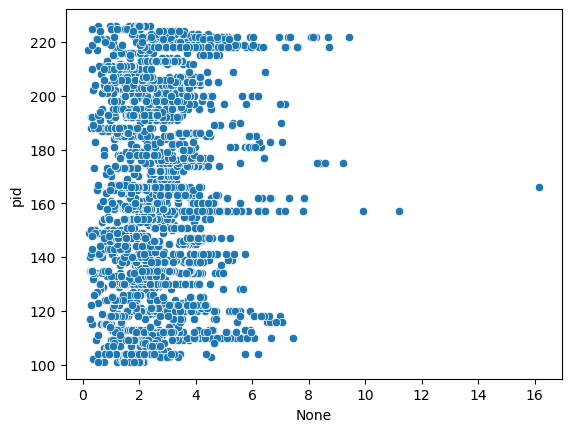

In [ ]:
sns.scatterplot(x=(data.end-data.start), y=data.pid)

<Axes: ylabel='None'>

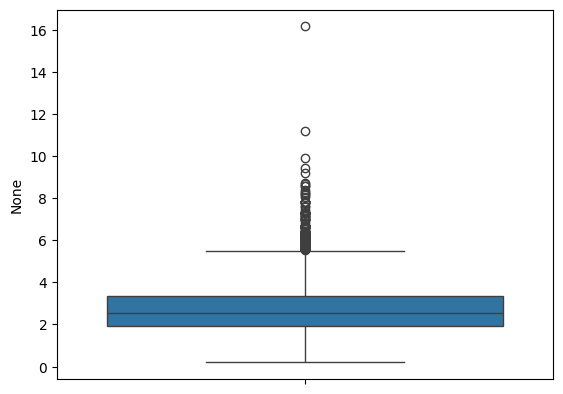

In [ ]:
sns.boxplot(y=(data.end-data.start))

A boxplot is a standardized way of displaying the distribution of data based on a five number summary (“minimum”, first quartile [Q1], median, third quartile [Q3] and “maximum”).

From these plots we can conclude that best length is ~6
Also if difference is <6 we must Zero Pad it to get it to required length.

Zero-padding refers to the process of symmetrically adding zeroes to the input matrix. It's a commonly used modification that allows the size of the input to be adjusted to our requirement.

Here zero padding would mean silence.

In [ ]:
# directory to store our processed audio files
isProcessedAudioFilesExist = os.path.exists('processed_audio_files')
isProcessedAudioFilesExistFlag = False

if(not isProcessedAudioFilesExist):
    os.makedirs('processed_audio_files')
    isProcessedAudioFilesExistFlag = True
isProcessedAudioFilesExist

True

A single sample of audio file can have Many Respiratory Cycles so we might have same multiple files for a single audio file

We will be using Librosa module for loading audio files and Soundfile module for writing to output path

Librosa - A python package for music and audio analysis. Librosa also normalizes the audio array.

Soundfile - The soundfile module is an audio library based on libsndfile, CFFI and NumPy. It can read and write sound files.

In [ ]:
# how single data looks in our dataframe
import librosa as lb
for index,row in data.iterrows():
    print("Index:",index)
    print("DataRow:\n",row)
    audio_file_loc=path + row['filename'] + '.wav'
    audioArr,sampleRate=lb.load(audio_file_loc)
    print("sr:",sampleRate)
    break

Index: 0
DataRow:
 start                        1.962
end                          6.553
crackles                         0
wheezes                          1
pid                            160
mode                            mc
filename    160_1b4_Tc_mc_AKGC417L
disease                       COPD
Name: 0, dtype: object
sr: 22050


In [ ]:
import soundfile as sf
import librosa as lb
import numpy as np


i, cnt = 0, 0

for index, row in data.iterrows():
    maxLen = 12
    start = row['start']
    end = row['end']
    filename = row['filename']

    # If len > maxLen, change len to maxLen
    if end - start > maxLen:
        end = start + maxLen

    audio_file_loc = path + filename + '.wav'

    if index > 0:
        # Check if more cycles exist for same patient if so then add i to change filename
        if data.iloc[index-1]['filename'] == filename:
            i += 1
        else:
            i = 0
    filename = filename + '_' + str(i) + '.wav'

    save_path = 'processed_audio_files/' + filename
    cnt += 1

    # Load audio file
    audioArr, sampleRate = lb.load(audio_file_loc)
    pureSample = getPureSample(audioArr, start, end, sampleRate)

    # Calculate padding
    reqLen = 6 * sampleRate
    current_len = len(pureSample)
    pad_length = reqLen - current_len

    if pad_length > 0:
        # Calculate padding for both sides
        pad_left = pad_length // 2
        pad_right = pad_length - pad_left
        # Pad the audio array
        padded_data = np.pad(pureSample, (pad_left, pad_right), mode='constant')
    else:
        padded_data = pureSample[:reqLen]
    print(f'{cnt} Files Processed out of ')
    sf.write(file=save_path, data=padded_data, samplerate=sampleRate)
print('Total Files Processed: ', cnt)

Streaming output truncated to the last 5000 lines.
1900 Files Processed out of 
1901 Files Processed out of 
1902 Files Processed out of 
1903 Files Processed out of 
1904 Files Processed out of 
1905 Files Processed out of 
1906 Files Processed out of 
1907 Files Processed out of 
1908 Files Processed out of 
1909 Files Processed out of 
1910 Files Processed out of 
1911 Files Processed out of 
1912 Files Processed out of 
1913 Files Processed out of 
1914 Files Processed out of 
1915 Files Processed out of 
1916 Files Processed out of 
1917 Files Processed out of 
1918 Files Processed out of 
1919 Files Processed out of 
1920 Files Processed out of 
1921 Files Processed out of 
1922 Files Processed out of 
1923 Files Processed out of 
1924 Files Processed out of 
1925 Files Processed out of 
1926 Files Processed out of 
1927 Files Processed out of 
1928 Files Processed out of 
1929 Files Processed out of 
1930 Files Processed out of 
1931 Files Processed out of 
1932 Files Processed 

## EDA, Handling Imbalance & Creating Spectrogram

In [ ]:
patient_info = pd.read_csv("demographic_info.txt", names=['Patient', 'Age', 'Sex', 'BMI', 'Weight', 'Height'], delim_whitespace=True)

<ipython-input-30-11c056933ffb>:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  patient_info = pd.read_csv("demographic_info.txt", names=['Patient', 'Age', 'Sex', 'BMI', 'Weight', 'Height'], delim_whitespace=True)


In [ ]:
patient_info.head()

,Patient,Age,Sex,BMI,Weight,Height
0,101,3.00,F,NaN,19.0,99.0
1,102,0.75,F,NaN,9.8,73.0
2,103,70.00,F,33.00,NaN,NaN
3,104,70.00,F,28.47,NaN,NaN
4,105,7.00,F,NaN,32.0,135.0


In [ ]:
patient_info['Sex'].value_counts()

,count
Sex,
M,79
F,46


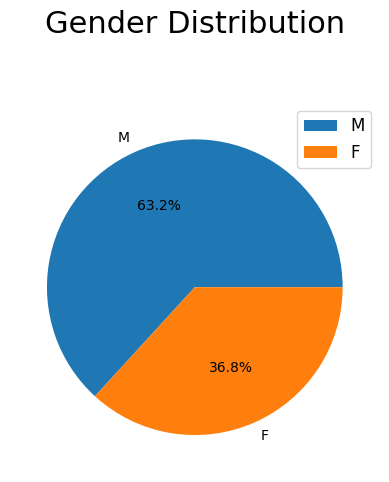

In [ ]:
plt.pie(patient_info['Sex'].value_counts(), labels = ['M','F'], autopct='%1.1f%%')
plt.title("Gender Distribution", fontsize=22, pad=50.0)
plt.legend(fontsize=12, loc='best', bbox_to_anchor=(1, 1));
plt.show()

In [ ]:
import IPython.display as ipd

In [ ]:
'''
Loading And Playing Audio Files
'''
filePath = 'processed_audio_files/226_1b1_Pl_sc_LittC2SE_7.wav'
ipd.Audio(filePath)

In [ ]:
# librosa can convert stereo to mono audio
audio1,sample_rate1 = librosa.load(filePath,  mono=True)

<ipython-input-37-b3251167e771>:6: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(audio1,sr=sample_rate1, max_points=50000, x_axis='time', offset=0)


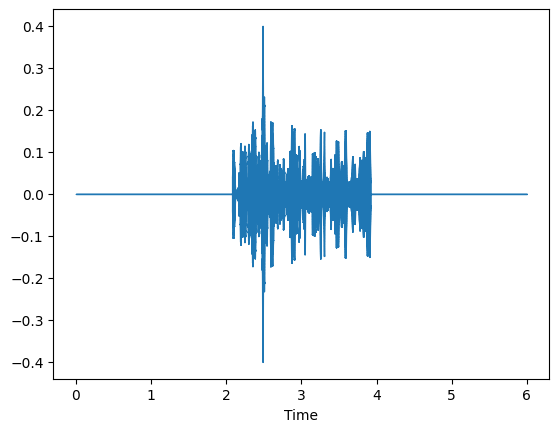

In [ ]:
'''
The sampling rate is the number of samples per second. Hz or Hertz is the unit of the sampling rate.
20 kHz is the audible range for human beings.
'''

librosa.display.waveshow(audio1,sr=sample_rate1, max_points=50000, x_axis='time', offset=0)

In [ ]:
import seaborn as sns
patient_data = pd.read_csv('/content/drive/MyDrive/runs/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv',names=['pid','disease'])
patient_data.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


<ipython-input-40-2fee0f544d75>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'disease', data = patient_data, palette = "bright")


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'URTI'),
  Text(1, 0, 'Healthy'),
  Text(2, 0, 'Asthma'),
  Text(3, 0, 'COPD'),
  Text(4, 0, 'LRTI'),
  Text(5, 0, 'Bronchiectasis'),
  Text(6, 0, 'Pneumonia'),
  Text(7, 0, 'Bronchiolitis')])

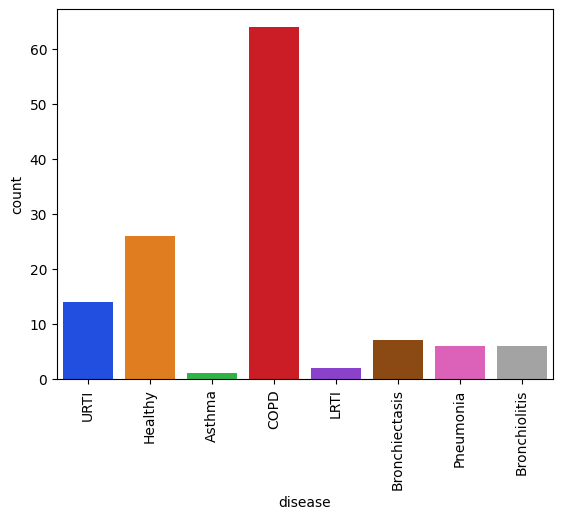

In [ ]:
sns.countplot(x = 'disease', data = patient_data, palette = "bright")
plt.xticks(rotation=90)


In [ ]:
# show count of each category in a column
patient_data['disease'].value_counts()

,count
disease,
COPD,64
Healthy,26
URTI,14
Bronchiectasis,7
Bronchiolitis,6
Pneumonia,6
LRTI,2
Asthma,1


We can see that classes are imbalanced so we must split them into train and validation set via stratify.

We will try to extract Id of each processed audio file and then merge them with their respective class label so we can split files in to train and validation folder in stratified manner.

In [ ]:
def extractId(filename):
    return filename.split('_')[0]

In [ ]:
path='processed_audio_files/'
length=len(os.listdir(path))
index=range(length)
i=0
files_df=pd.DataFrame(index=index,columns=['pid','filename'])
for f in os.listdir(path):
    files_df.iloc[i]['pid']=extractId(f)
    files_df.iloc[i]['filename']=f
    i+=1
files_df.head()

<ipython-input-43-db383c60cadc>:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  files_df.iloc[i]['pid']=extractId(f)
<ipython-input-43-db383c60cadc>:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are sett

,pid,filename
0,127,127_1b1_Ar_sc_Meditron_3.wav
1,127,127_1b1_Ar_sc_Meditron_4.wav
2,127,127_1b1_Ar_sc_Meditron_5.wav
3,127,127_1b1_Ar_sc_Meditron_6.wav
4,127,127_1b1_Ar_sc_Meditron_7.wav


In [ ]:
files_df.pid=files_df.pid.astype('int64') # both pid's must be of same dtype for them to merge

In [ ]:
data=pd.merge(files_df,patient_data,on='pid')
data.head()

,pid,filename,disease
0,127,127_1b1_Ar_sc_Meditron_3.wav,Healthy
1,127,127_1b1_Ar_sc_Meditron_4.wav,Healthy
2,127,127_1b1_Ar_sc_Meditron_5.wav,Healthy
3,127,127_1b1_Ar_sc_Meditron_6.wav,Healthy
4,127,127_1b1_Ar_sc_Meditron_7.wav,Healthy


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'URTI'),
  Text(1, 0, 'Healthy'),
  Text(2, 0, 'Asthma'),
  Text(3, 0, 'COPD'),
  Text(4, 0, 'LRTI'),
  Text(5, 0, 'Bronchiectasis'),
  Text(6, 0, 'Pneumonia'),
  Text(7, 0, 'Bronchiolitis')])

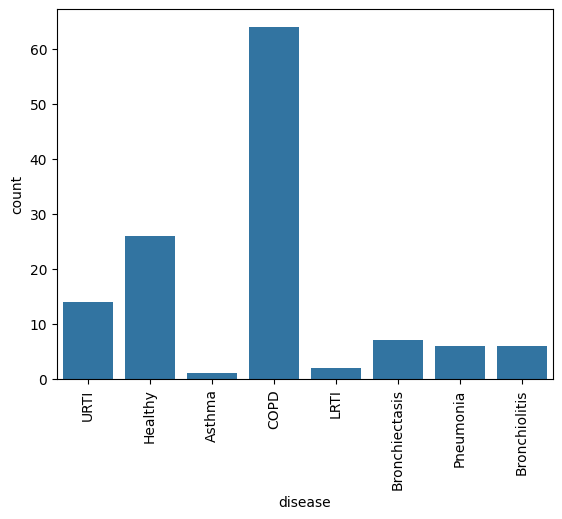

In [ ]:
sns.countplot(x = 'disease', data = patient_data)
plt.xticks(rotation=90)

We can see that classes are very skewed

In [ ]:
from sklearn.model_selection import train_test_split
Xtrain,Xval,ytrain,yval=train_test_split(data,data.disease,stratify=data.disease,random_state=42,test_size=0.2)

stratify data based on class labels and split accordingly

In [ ]:
Xtrain.disease.value_counts()/Xtrain.shape[0]

,count
disease,
COPD,0.832910
Healthy,0.046756
Pneumonia,0.041319
URTI,0.035158
Bronchiolitis,0.023197
Bronchiectasis,0.015042
LRTI,0.004712
Asthma,0.000906


In [ ]:
Xval.disease.value_counts()/Xval.shape[0]

,count
disease,
COPD,0.833333
Healthy,0.046377
Pneumonia,0.041304
URTI,0.035507
Bronchiolitis,0.023188
Bronchiectasis,0.015217
LRTI,0.004348
Asthma,0.000725


% of class labels is same in both train and val data set

This will help our model to learn and validate classes , it will not be like we are training only on COPD disease and there is no COPD in our validation

Visualizing Mel-Frequency Cepstral Coefficients (MFCCS)

[Text(0.5, 1.0, 'MFCC')]

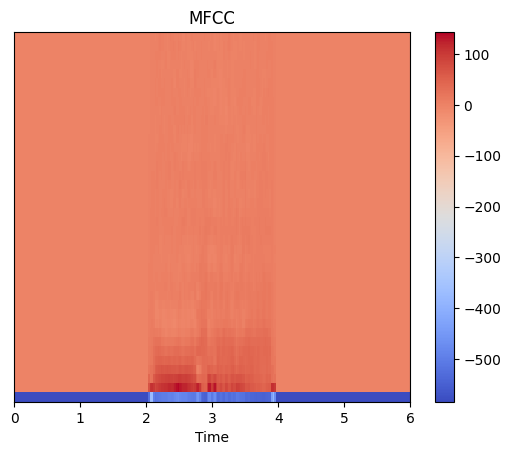

In [ ]:
# Using one file for demo
sound,sample_rate=lb.load(filePath)
mfccs = lb.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40)
fig, ax = plt.subplots()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

x-axis = time, y-axis = decibels

In [ ]:
mfccs.shape

(40, 259)

The first dimension (40) is the number of MFCC coefficients, and the second dimensions (1876) is the number of time frames. The number of MFCC is specified by n_mfcc, and the number of time frames is given by the length of the audio (in samples) divided by the hop_length

In [ ]:
Xtrain.head()

,pid,filename,disease
2543,178,178_2b2_Lr_mc_AKGC417L_6.wav,COPD
2517,174,174_1p3_Pl_mc_AKGC417L_3.wav,COPD
6481,191,191_2b2_Tc_mc_LittC2SE_3.wav,Pneumonia
5369,122,122_2b3_Al_mc_LittC2SE_1.wav,Pneumonia
1880,178,178_1b3_Ar_mc_AKGC417L_0.wav,COPD


In [ ]:
ytrain.head()

,disease
2543,COPD
2517,COPD
6481,Pneumonia
5369,Pneumonia
1880,COPD


In [ ]:
Xval.head()

,pid,filename,disease
2314,160,160_2b4_Pl_mc_AKGC417L_6.wav,COPD
2039,115,115_1b1_Ar_sc_Meditron_19.wav,LRTI
953,187,187_1b1_Ll_sc_Meditron_0.wav,Healthy
4469,178,178_2b2_Ar_mc_AKGC417L_7.wav,COPD
2684,107,107_2b4_Lr_mc_AKGC417L_2.wav,COPD


In [ ]:
yval.head

<bound method NDFrame.head of 2314             COPD
2039             LRTI
953           Healthy
4469             COPD
2684             COPD
            ...      
922     Bronchiolitis
2355             URTI
3365             COPD
1252             COPD
5714             COPD
Name: disease, Length: 1380, dtype: object>

In [ ]:
# Save training and validation data
TrainingFileExist = os.path.exists('training')
ValidationFileExist = os.path.exists('validation')

# os.makedirs('training')
Xtrain.to_csv('training/train.csv')

# os.makedirs('validation')
Xval.to_csv('validation/val.csv')

Further Steps:
- Feature Extraction using MFCC, Chroma STFT, Mel Spectrogram
- Building Our Neural Network Model
- Testing the model
- comparing our model
- Developing flask app for our model deployment

In [ ]:
train=pd.read_csv('training/train.csv')
val=pd.read_csv('validation/val.csv')
train.head()

,Unnamed: 0,pid,filename,disease
0,2543,178,178_2b2_Lr_mc_AKGC417L_6.wav,COPD
1,2517,174,174_1p3_Pl_mc_AKGC417L_3.wav,COPD
2,6481,191,191_2b2_Tc_mc_LittC2SE_3.wav,Pneumonia
3,5369,122,122_2b3_Al_mc_LittC2SE_1.wav,Pneumonia
4,1880,178,178_1b3_Ar_mc_AKGC417L_0.wav,COPD


In [ ]:
ytrain=train.disease
yval=val.disease
yval

,disease
0,COPD
1,LRTI
2,Healthy
3,COPD
4,COPD
...,...
1375,Bronchiolitis
1376,URTI
1377,COPD
1378,COPD


In [ ]:
yval.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1380 entries, 0 to 1379
Series name: disease
Non-Null Count  Dtype 
--------------  ----- 
1380 non-null   object
dtypes: object(1)
memory usage: 10.9+ KB


class labels are of dtype: object we must first convert them to encoded values or intergers

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
ytrain=le.fit_transform(ytrain)
yval=le.transform(yval)

In [ ]:
yval

array([3, 5, 4, ..., 3, 3, 3])

## Feature Extraction

In [ ]:
def getFeatures(path):
    soundArr,sample_rate=lb.load(path)
    mfcc=lb.feature.mfcc(y=soundArr,sr=sample_rate)
    cstft=lb.feature.chroma_stft(y=soundArr,sr=sample_rate)
    mSpec=lb.feature.melspectrogram(y=soundArr,sr=sample_rate)

    return mfcc,cstft,mSpec

In These functions we are iterating over train and val dataset, and using filenames to extract features and then converting them to numpy arrays

In [ ]:
root='processed_audio_files/'
mfcc,cstft,mSpec = [],[],[]

for idx,row in train.iterrows():
    path=root + row['filename']
    a,b,c=getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)

mfcc_train=np.array(mfcc)
cstft_train=np.array(cstft)
mSpec_train=np.array(mSpec)

/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [ ]:
mfcc_train

array([[[-655.0549 , -655.0549 , -655.0549 , ..., -655.0549 ,
         -655.0549 , -655.0549 ],
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        ...,
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ]],

       [[-471.02448, -471.02448, -471.02448, ..., -471.02448,
         -471.02448, -471.02448],
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        ...,
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        [   

In [ ]:
# saving variables so we do not have to extract them again
# convert 3d arr to 2d to save it
# while loading need to reshape back to 3d

mfcc_reshaped = mfcc_train.reshape(mfcc_train.shape[0], -1)
cstft_reshaped = cstft_train.reshape(cstft_train.shape[0], -1)
mSpec_reshaped = mSpec_train.reshape(mSpec_train.shape[0], -1)
print(mfcc_reshaped)
np.savetxt('mfcc_variable_train.txt', mfcc_reshaped)
np.savetxt('cstft_variable_train.txt', cstft_reshaped)
np.savetxt('mSpec_variable_train.txt', mSpec_reshaped)

[[-655.0549  -655.0549  -655.0549  ...    0.         0.         0.     ]
 [-471.02448 -471.02448 -471.02448 ...    0.         0.         0.     ]
 [-592.35583 -592.35583 -592.35583 ...    0.         0.         0.     ]
 ...
 [-513.72723 -513.72723 -513.72723 ...    0.         0.         0.     ]
 [-688.7041  -688.7041  -688.7041  ...    0.         0.         0.     ]
 [-464.9923  -464.9923  -464.9923  ...    0.         0.         0.     ]]


In [ ]:
# loading variable files
mfcc_train = np.loadtxt('mfcc_variable_train.txt')
cstft_train = np.loadtxt('cstft_variable_train.txt')
mSpec_train = np.loadtxt('mSpec_variable_train.txt')

In [ ]:
mfcc_train

array([[-655.05487061, -655.05487061, -655.05487061, ...,    0.        ,
           0.        ,    0.        ],
       [-471.0244751 , -471.0244751 , -471.0244751 , ...,    0.        ,
           0.        ,    0.        ],
       [-592.35583496, -592.35583496, -592.35583496, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [-513.72723389, -513.72723389, -513.72723389, ...,    0.        ,
           0.        ,    0.        ],
       [-688.70410156, -688.70410156, -688.70410156, ...,    0.        ,
           0.        ,    0.        ],
       [-464.99230957, -464.99230957, -464.99230957, ...,    0.        ,
           0.        ,    0.        ]])

In [ ]:
# back to original variable
mfcc_train = mfcc_train.reshape(
    mfcc_train.shape[0], mfcc_train.shape[1] // 259 , 259)

mfcc_train   # original mfcc array mfcc.shape[2] = 259 (back to 3d array)

array([[[-655.05487061, -655.05487061, -655.05487061, ...,
         -655.05487061, -655.05487061, -655.05487061],
        [   0.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        ...,
        [   0.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ]],

       [[-471.0244751 , -471.0244751 , -471.0244751 , ...,
         -471.0244751 , -471.0244751 , -471.0244751 ],
        [   0.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        , ...,
            0.

In [ ]:
# back to original variable
cstft_train = cstft_train.reshape(
    cstft_train.shape[0], cstft_train.shape[1] // 259 , 259)

cstft_train   # original mfcc array cstft_train.shape[2] = 259

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [ ]:
# back to original variable
mSpec_train = mSpec_train.reshape(
    mSpec_train.shape[0], mSpec_train.shape[1] // 259 , 259)

mSpec_train   # original mfcc array mSpec_train.shape[2] = 259

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

Chroma STFT The Chroma value of an audio basically represent the intensity of the twelve distinctive pitch classes that are used to study music. They can be employed in the differentiation of the pitch class profiles between audio signals. Chroma STFT in used short-term Fourier transformation to compute Chroma features. STFT represents information about the classification of pitch and signal structure. It depicts the spike with high values (as evident from the color bar net to the graph) in low values (dark regions).

Need to plot graph

In [ ]:
mfcc,cstft,mSpec = [],[],[]

for idx,row in val.iterrows():
    path=root + row['filename']
    a,b,c=getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)

mfcc_val=np.array(mfcc)
cstft_val=np.array(cstft)
mSpec_val=np.array(mSpec)

In [ ]:
mfcc_val

array([[[-503.29437, -503.29437, -503.29437, ..., -503.29437,
         -503.29437, -503.29437],
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        ...,
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ]],

       [[-655.4843 , -655.4843 , -655.4843 , ..., -655.4843 ,
         -655.4843 , -655.4843 ],
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        ...,
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        [   

In [ ]:
print(mfcc_val.shape)
print(cstft_val.shape)
print(mSpec_val.shape)

(1380, 20, 259)
(1380, 12, 259)
(1380, 128, 259)


In [ ]:
mfcc_train.shape

(5518, 20, 259)

In [ ]:
cstft_train.shape

(5518, 12, 259)

In [ ]:
mSpec_train.shape

(5518, 128, 259)

The shape of features returned by the above function (20, 259) (12, 259) (128, 259) we need this for defining input shape of our model.

In [ ]:
mfcc_reshaped = mfcc_val.reshape(mfcc_val.shape[0], -1)
cstft_reshaped = cstft_val.reshape(cstft_val.shape[0], -1)
mSpec_reshaped = mSpec_val.reshape(mSpec_val.shape[0], -1)
print(mfcc_reshaped)
np.savetxt('mfcc_variable_val.txt', mfcc_reshaped)
np.savetxt('cstft_variable_val.txt', cstft_reshaped)
np.savetxt('mSpec_variable_val.txt', mSpec_reshaped)

[[-503.29437 -503.29437 -503.29437 ...    0.         0.         0.     ]
 [-655.4843  -655.4843  -655.4843  ...    0.         0.         0.     ]
 [-563.47516 -563.47516 -563.47516 ...    0.         0.         0.     ]
 ...
 [-489.78522 -489.78522 -489.78522 ...    0.         0.         0.     ]
 [-571.36163 -571.36163 -571.36163 ...    0.         0.         0.     ]
 [-520.69086 -520.69086 -520.69086 ...    0.         0.         0.     ]]


In [ ]:
# loading variable files
mfcc_val = np.loadtxt('mfcc_variable_val.txt')
cstft_val = np.loadtxt('cstft_variable_val.txt')
mSpec_val = np.loadtxt('mSpec_variable_val.txt')

In [ ]:
mfcc_val = mfcc_val.reshape(
    mfcc_val.shape[0], mfcc_val.shape[1] // 259 , 259)
cstft_val = cstft_val.reshape(
    cstft_val.shape[0], cstft_val.shape[1] // 259 , 259)
mSpec_val = mSpec_val.reshape(
    mSpec_val.shape[0], mSpec_val.shape[1] // 259 , 259)

In [ ]:
mfcc_val.shape

(1380, 20, 259)

## Building Model

In [ ]:
# Lets create model using Keras Functional API to check how the features perform.
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001,mode='min')
]

### Here we are creating three different neural networks and then Combining them to a Dense Network

In [ ]:
mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mfcc_output=keras.layers.GlobalMaxPooling2D()(x)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")

In [ ]:
mfcc_model.summary()

Model: "mfccModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mfccInput (InputLayer)               │ (None, 20, 259, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 20, 87, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 20, 87, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 20, 87, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 10, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 22, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 10, 22, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 10, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 11, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 5, 11, 96)           │          24,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 5, 11, 96)           │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 5, 11, 96)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 5, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 5, 128)           │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 2, 5, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 2, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,560 (369.38 KB)

 Trainable params: 93,920 (366.88 KB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
croma_input=keras.layers.Input(shape=(12,259,1),name="cromaInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(croma_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
croma_output=keras.layers.GlobalMaxPooling2D()(x)

croma_model=keras.Model(croma_input, croma_output, name="cromaModel")

In [ ]:
croma_model.summary()

Model: "cromaModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ cromaInput (InputLayer)              │ (None, 12, 259, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 87, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 12, 87, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 12, 87, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 43, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 6, 22, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 6, 22, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 6, 22, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 3, 11, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 3, 11, 128)          │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 3, 11, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 3, 11, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d_1               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,120 (207.50 KB)

 Trainable params: 52,672 (205.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
mSpec_input=keras.layers.Input(shape=(128,259,1),name="mSpecInput")
x=keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(2,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mSpec_output=keras.layers.GlobalMaxPooling2D()(x)

mSpec_model=keras.Model(mSpec_input, mSpec_output, name="mSpecModel")

In [ ]:
mSpec_model.summary()

Model: "mSpecModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mSpecInput (InputLayer)              │ (None, 128, 259, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 87, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64, 87, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 64, 87, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 22, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16, 22, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 16, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 8, 11, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 11, 96)           │          24,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 8, 11, 96)           │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 8, 11, 96)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 4, 5, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 4, 5, 128)           │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 4, 5, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 4, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d_2               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,560 (369.38 KB)

 Trainable params: 93,920 (366.88 KB)

 Non-trainable params: 640 (2.50 KB)

Concatenating our 3 models

In [ ]:
input_mfcc=keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfcc_model(input_mfcc)

input_croma=keras.layers.Input(shape=(12,259,1),name="croma")
croma=croma_model(input_croma)

input_mSpec=keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec=mSpec_model(input_mSpec)


concat=keras.layers.concatenate([mfcc,croma,mSpec])
hidden=keras.layers.Dropout(0.1)(concat)
hidden=keras.layers.Dense(50,activation='relu')(concat)
hidden=keras.layers.Dropout(0.2)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.2)(hidden)
output=keras.layers.Dense(8,activation='softmax')(hidden)

net=keras.Model([input_mfcc,input_croma,input_mSpec], output, name="Net")

In [ ]:
net.summary()

Model: "Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ mfcc (InputLayer)         │ (None, 20, 259, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ croma (InputLayer)        │ (None, 12, 259, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mspec (InputLayer)        │ (None, 128, 259, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mfccModel (Functional)    │ (None, 128)            │         94,560 │ mfcc[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cromaModel (Functional)   │ (None, 128)            │         53,120 │ croma[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mSpecModel (Functional)   │ (None, 128)            │         94,560 │ mspec[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 384)            │              0 │ mfccModel[0][0],       │
│                           │                        │                │ cromaModel[0][0],      │
│                           │                        │                │ mSpecModel[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 50)             │         19,250 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 50)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 25)             │          1,275 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 25)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 8)              │            208 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 262,973 (1.00 MB)

 Trainable params: 261,245 (1020.49 KB)

 Non-trainable params: 1,728 (6.75 KB)

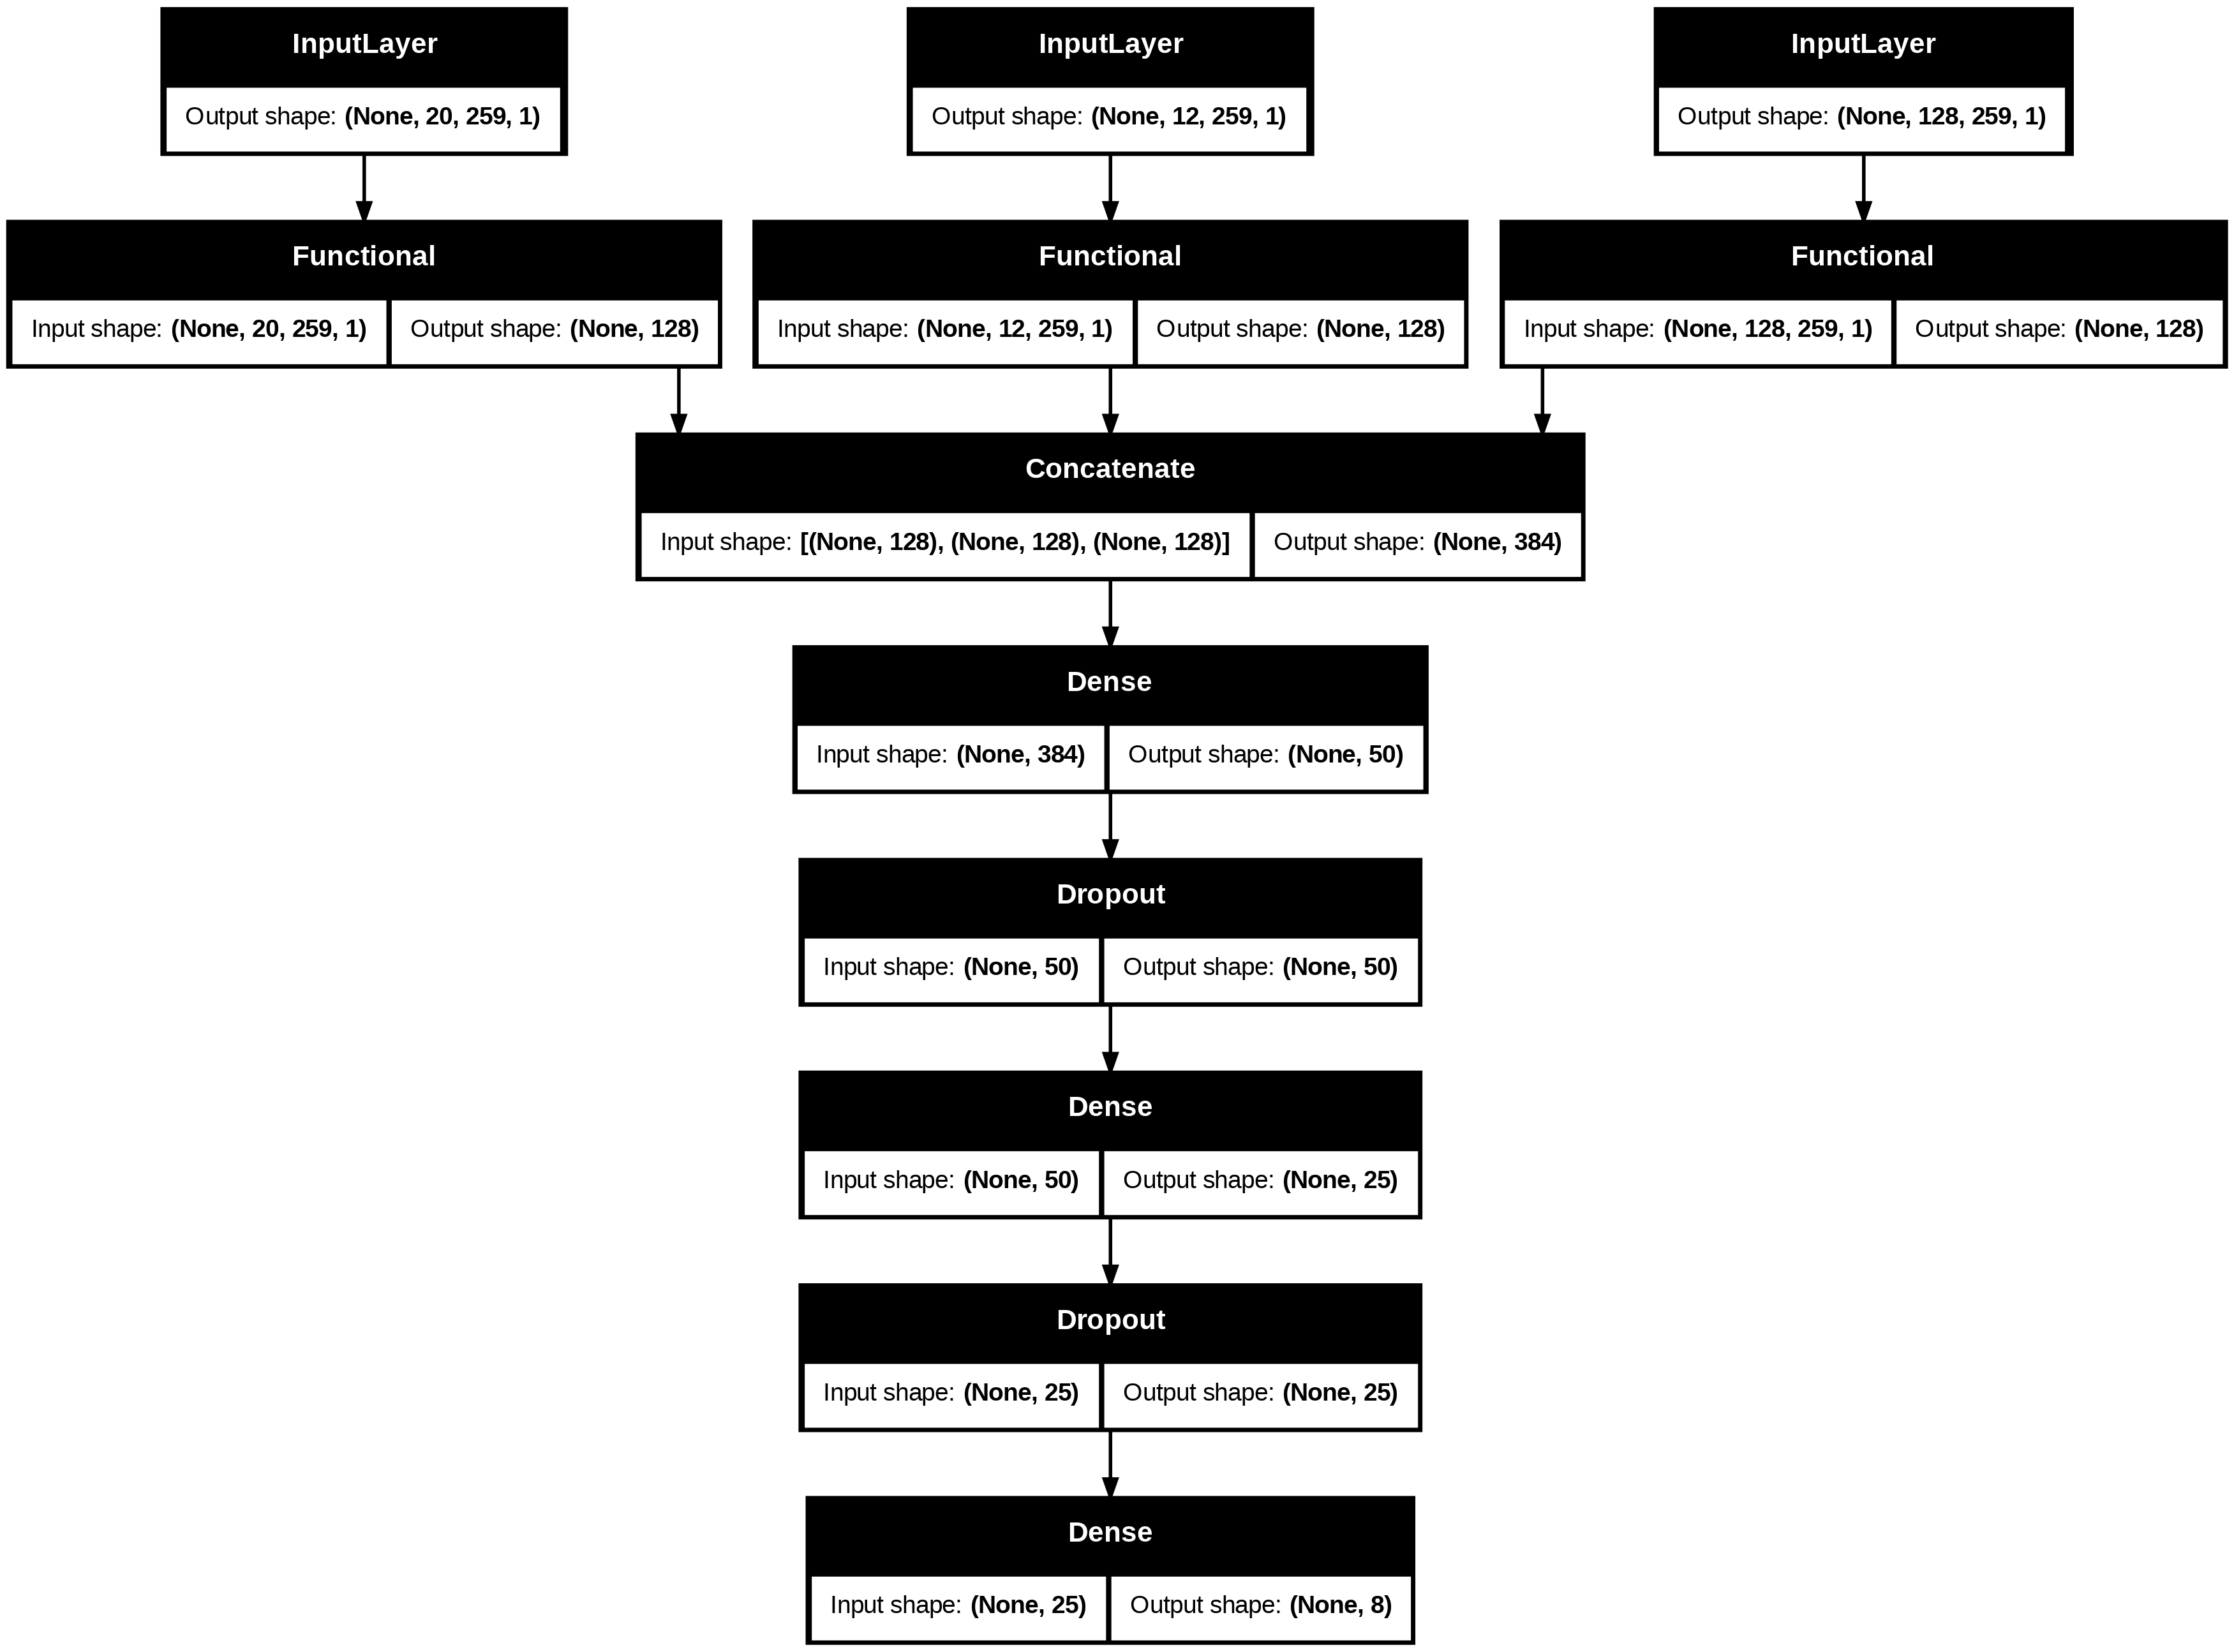

In [ ]:
keras.utils.plot_model(net, "combined_model.png", show_shapes=True)

In [ ]:
from keras import backend as K
net.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
net.optimizer.learning_rate.assign(0.001)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0010000000474974513>

In [ ]:
history=net.fit(
    {"mfcc":mfcc_train,"croma":cstft_train,"mspec":mSpec_train},
    ytrain,
    validation_data=({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval),
    epochs=15,verbose=1,
    callbacks=my_callbacks
)

Epoch 1/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.9714 - loss: 0.0784 - val_accuracy: 0.9377 - val_loss: 0.2583 - learning_rate: 0.0010
Epoch 2/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9712 - loss: 0.0872 - val_accuracy: 0.9304 - val_loss: 0.4039 - learning_rate: 0.0010
Epoch 3/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9736 - loss: 0.0718 - val_accuracy: 0.9268 - val_loss: 0.4254 - learning_rate: 0.0010
Epoch 4/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9702 - loss: 0.0799 - val_accuracy: 0.9261 - val_loss: 0.2720 - learning_rate: 0.0010
Epoch 5/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9719 - loss: 0.0713 - val_accuracy: 0.9594 - val_loss: 0.1679 - learning_rate: 1.0000e-04
Epoch 6/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9865 - loss: 0.0414 - val_accuracy: 0.9594 - val_loss: 0.1758 - learning_rate: 1.0000e-04
Epoch 7/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9888 - loss:

In [ ]:
history.history['accuracy']

[0.9715476632118225,
 0.9704602956771851,
 0.9762595295906067,
 0.9690105319023132,
 0.974990963935852,
 0.9844146370887756,
 0.9871330261230469,
 0.9876766800880432,
 0.9864081144332886,
 0.9884015917778015,
 0.9884015917778015,
 0.9916636347770691,
 0.9902138710021973,
 0.9891265034675598]

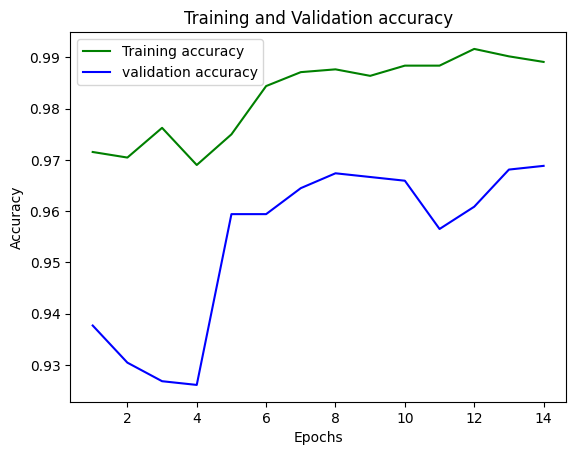

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,15)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

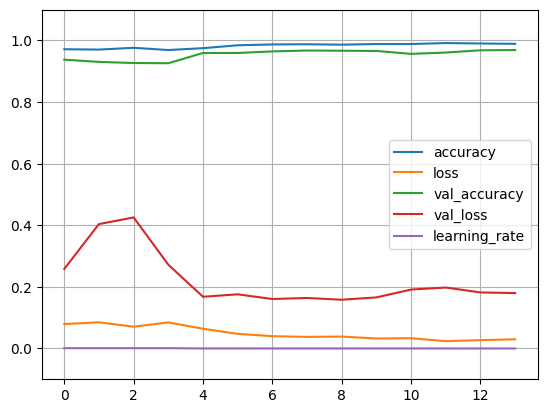

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1,1.1)
plt.show()

## Evaluating and Saving Our Model

In [ ]:
net.evaluate({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9643 - loss: 0.2228


[0.17986658215522766, 0.9688405990600586]

In [ ]:
yval

array([3, 5, 4, ..., 3, 3, 3])

In [ ]:
ypred = net.predict({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val})

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


In [ ]:
yPred = []
for i in ypred:
    yPred.append(np.argmax(i))
yPred

[3,
 7,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 7,
 6,
 3,
 3,
 3,
 3,
 6,
 3,
 3,
 3,
 3,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 6,
 3,
 4,
 3,
 3,
 6,
 3,
 3,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 7,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 7,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 1,
 4,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 7,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 7,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 7,
 3,
 3,
 3,
 3,
 6,
 3,
 3,
 3,
 6,
 3,
 7,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 1,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 7,
 3,
 3,
 6,
 3,
 4,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 6,
 3,
 3,
 3,
 2,
 7,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 6,
 3,
 3,
 3,
 6,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 7,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
print('\nClassification Report\n')
from sklearn.metrics import classification_report
print(classification_report(yval, yPred, target_names=['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'LRTI', 'Pneumonia', 'URTI']))


Classification Report

                precision    recall  f1-score   support

        Asthma       0.00      0.00      0.00         1
Bronchiectasis       1.00      0.90      0.95        21
 Bronchiolitis       0.72      0.81      0.76        32
          COPD       0.99      1.00      0.99      1150
       Healthy       0.85      0.83      0.84        64
          LRTI       1.00      0.33      0.50         6
     Pneumonia       0.96      0.93      0.95        57
          URTI       0.81      0.78      0.79        49

      accuracy                           0.97      1380
     macro avg       0.79      0.70      0.72      1380
  weighted avg       0.97      0.97      0.97      1380



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# saving model
from tensorflow.keras.models import save_model
modelExist = os.path.exists('model')
if(not modelExist):
    os.makedirs('model')
save_model(net, "model/model2.h5")
    # net.save(filepath='model/',overwrite=True,include_optimizer=True)

## Testing our Model for single input sound file

In [ ]:
# load model
# model = keras.models.load_model('model') if model not saved in h5 format
from tensorflow.keras.models import load_model

# load model
model = load_model('model/model2.h5')
# summarize model.
model.summary()

Model: "Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ mfcc (InputLayer)         │ (None, 20, 259, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ croma (InputLayer)        │ (None, 12, 259, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mspec (InputLayer)        │ (None, 128, 259, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mfccModel (Functional)    │ (None, 128)            │         94,560 │ mfcc[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cromaModel (Functional)   │ (None, 128)            │         53,120 │ croma[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mSpecModel (Functional)   │ (None, 128)            │         94,560 │ mspec[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 384)            │              0 │ mfccModel[0][0],       │
│                           │                        │                │ cromaModel[0][0],      │
│                           │                        │                │ mSpecModel[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 50)             │         19,250 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 50)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 25)             │          1,275 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 25)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 8)              │            208 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 262,976 (1.00 MB)

 Trainable params: 261,245 (1020.49 KB)

 Non-trainable params: 1,728 (6.75 KB)

 Optimizer params: 3 (16.00 B)

In [ ]:
model.summary(expand_nested=True)

Model: "Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ mfcc (InputLayer)         │ (None, 20, 259, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ croma (InputLayer)        │ (None, 12, 259, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mspec (InputLayer)        │ (None, 128, 259, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mfccModel (Functional)    │ (None, 128)            │         94,560 │ mfcc[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ mfccInput            │ (None, 20, 259, 1)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ conv2d (Conv2D)      │ (None, 20, 87, 32)     │            832 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ batch_normalization  │ (None, 20, 87, 32)     │            128 │ -                      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ activation           │ (None, 20, 87, 32)     │              0 │ -                      │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ max_pooling2d        │ (None, 10, 43, 32)     │              0 │ -                      │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ conv2d_1 (Conv2D)    │ (None, 10, 22, 64)     │         18,496 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └                      │ (None, 10, 22, 64)     │            256 │ -                      │
│ batch_normalization_1     │                        │                │                        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ activation_1         │ (None, 10, 22, 64)     │              0 │ -                      │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ max_pooling2d_1      │ (None, 5, 11, 64)      │              0 │ -                      │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ conv2d_2 (Conv2D)    │ (None, 5, 11, 96)      │         24,672 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └                      │ (None, 5, 11, 96)      │            384 │ -                      │
│ batch_normalization_2     │                        │                │                        │
│ (BatchNormalization) 

 Total params: 262,976 (1.00 MB)

 Trainable params: 261,245 (1020.49 KB)

 Non-trainable params: 1,728 (6.75 KB)

 Optimizer params: 3 (16.00 B)

In [ ]:
import librosa as lb
def getFeaturesForNeuralNetwork(path):
    soundArr,sample_rate=lb.load(path)
    mfcc=lb.feature.mfcc(y=soundArr,sr=sample_rate)
    cstft=lb.feature.chroma_stft(y=soundArr,sr=sample_rate)
    mSpec=lb.feature.melspectrogram(y=soundArr,sr=sample_rate)

    return mfcc,cstft,mSpec

In [ ]:
# testing soundfile path

COPD = "113_1b1_Ll_sc_Litt3200_2.wav"
Pneumonia = "135_2b3_Al_mc_LittC2SE_3.wav"
URTI = "119_1b1_Ar_sc_Meditron_0.wav"
Healthy = "159_1b1_Ar_sc_Meditron_3.wav"
Bronchiectasis = "111_1b2_Tc_sc_Meditron_2.wav"
Bronchiolitis = "149_1b1_Pl_sc_Meditron_10.wav"
Asthma = "103_2b2_Ar_mc_LittC2SE_3.wav"

soundFilePath = "/content/drive/MyDrive/runs/processed_audio_files/" + COPD
print(os.getcwd())
print(soundFilePath)

/content/drive/MyDrive/runs
/content/drive/MyDrive/runs/processed_audio_files/113_1b1_Ll_sc_Litt3200_2.wav


In [ ]:
isExist = os.path.exists(soundFilePath)
print(isExist)

True


In [ ]:
mfcc_test, croma_test, mspec_test = getFeaturesForNeuralNetwork(soundFilePath)

In [ ]:
# cannot directly input mfcc_test, croma_test, mspec_test, be careful of dimensions
import numpy as np
mfcc,cstft,mSpec = [],[],[]
mfcc.append(mfcc_test)
cstft.append(croma_test)
mSpec.append(mspec_test)

mfcc_test = np.array(mfcc)
cstft_test = np.array(cstft)
mspec_test = np.array(mSpec)
print(mfcc_test.shape)
print(cstft_test.shape)
print(mspec_test.shape)

(1, 20, 259)
(1, 12, 259)
(1, 128, 259)


In [ ]:
result = model.predict({"mfcc":mfcc_test,"croma":cstft_test,"mspec":mspec_test})

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [ ]:
# print(le.classes_)
# After label encoding we get
# array(['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy',
#        'LRTI', 'Pneumonia', 'URTI'], dtype=object)
diseaseArray = ['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'LRTI', 'Pneumonia', 'URTI']
result = result.flatten()
indexMax = np.argmax(result)
indexSecMax = 0
secMax = result[0]
for smx in range(len(result)):
    if(result[smx] > secMax and result[smx] < result[indexMax]):
        indexSecMax = smx
        secMax = result[smx]

# print(index)
print(result)
print(indexSecMax)

[5.0485571e-30 3.8696218e-23 4.0295946e-29 1.0000000e+00 1.3799885e-22
 2.2333194e-39 3.8103491e-19 6.8189117e-39]
6


In [ ]:
# 2 most prominent disorders
print("Disorders Detected:")
print("respiratory disorder detected: " + str(diseaseArray[indexMax]) + " with probability " + str(result[indexMax] * 100) + "%")
print("respiratory disorder detected: " + str(diseaseArray[indexSecMax]) + " with probability " + str(result[indexSecMax] * 100) + "%")


Disorders Detected:
respiratory disorder detected: COPD with probability 100.0%
respiratory disorder detected: Pneumonia with probability 3.8103490720947604e-17%


In [ ]:
import os
import tensorflow
from tensorflow import keras
import numpy as np
from tensorflow.keras.models import load_model
import librosa as lb

# load model
model = load_model('model/model.h5')

def getFeaturesForNeuralNetwork(path):
    soundArr,sample_rate=lb.load(path)
    mfcc=lb.feature.mfcc(y=soundArr,sr=sample_rate)
    cstft=lb.feature.chroma_stft(y=soundArr,sr=sample_rate)
    mSpec=lb.feature.melspectrogram(y=soundArr,sr=sample_rate)

    return mfcc,cstft,mSpec

def classificationResults(soundFilePath):
    print(soundFilePath)
    isExist = os.path.exists(soundFilePath)
    if(isExist):
        mfcc_test, croma_test, mspec_test = getFeaturesForNeuralNetwork(soundFilePath)
        mfcc,cstft,mSpec = [],[],[]
        mfcc.append(mfcc_test)
        cstft.append(croma_test)
        mSpec.append(mspec_test)

        mfcc_test = np.array(mfcc)
        cstft_test = np.array(cstft)
        mspec_test = np.array(mSpec)

        result = model.predict({"mfcc":mfcc_test,"croma":cstft_test,"mspec":mspec_test})

        diseaseArray = ['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'LRTI', 'Pneumonia', 'URTI']
        result = result.flatten()
        indexMax = np.argmax(result)
        indexSecMax = 0
        secMax = result[0]
        for smx in range(len(result)):
            if(result[smx] > secMax and result[smx] < result[indexMax]):
                indexSecMax = smx
                secMax = result[smx]
        res1 = "respiratory disorder detected: " + str(diseaseArray[indexMax]) + " with probability " + str(result[indexMax] * 100) + "%"
        res2 = "respiratory disorder detected: " + str(diseaseArray[indexSecMax]) + " with probability " + str(result[indexSecMax] * 100) + "%"
        res_list = []
        res_list.append(res1)
        res_list.append(res2)
        return res_list
    else:
        err1 = "Sorry, No File Found"
        err2 = "Please upload the file in .wav format"
        res_list.append(err1)
        res_list.append(err2)
        return res_list

results = classificationResults("/content/drive/MyDrive/runs/processed_audio_files/101_1b1_Al_sc_Meditron_4.wav")
print("Classification complete!")
for result in results:
    print(result)

/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


/content/drive/MyDrive/runs/processed_audio_files/101_1b1_Al_sc_Meditron_4.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Classification complete!
respiratory disorder detected: Healthy with probability 48.13397526741028%
respiratory disorder detected: URTI with probability 27.051368355751038%
